# 8. Dimensionality reduction

In [2]:
%matplotlib inline
import warnings;warnings.filterwarnings('ignore');import matplotlib.pyplot as plt;import numpy as np;import pandas as pd;import seaborn as sns;sns.set_context("notebook", font_scale=1.4);sns.set_style("whitegrid");import imp;compomics_import = imp.load_source('compomics_import', '../compomics_import.py');from IPython.core.display import HTML;css_file = '../my.css';HTML(open(css_file, "r").read())

In many cases it can be useful to **reduce the number of features (dimensions)** in a data set before building a classification or regression model. Removing noisy features or decorrelating correlated features can prevent data overfitting. In addition it improves training times and decreases computer memory requirements. Finally when reducing the number of features to less than four we can actually take a look the data in for instance a scatterplot. 

In these final two chapters we take a look at some popular **dimensionality reduction** algorithms which can be roughly divided into two types: **feature extraction** and **feature selection**. The key idea for all of these approaches however is the same: while reducing the number of features try to preserve as much information as possible. For feature extraction we will discuss **Principle Components Analysis (PCA)** and **Multidimensional Scaling (MDS)**. These approaches compute a new set of features that does not include any of the original features. This is typically achieved by mapping the original data into a lower-dimensional space using some kind of transformation. In contrast feature selection reduces the number of features by selecting only those features that are relevant for the classification or regression task. 

PCA decomposes a data set in its principal components (PC) through a **linear** transformation. PC's (also called eigenvectors) are **orthogonal** to each other and point in the direction of **largest variance**. So what does this mean? Let's say we have a data set with two features and we want to reduce this data to one feature.

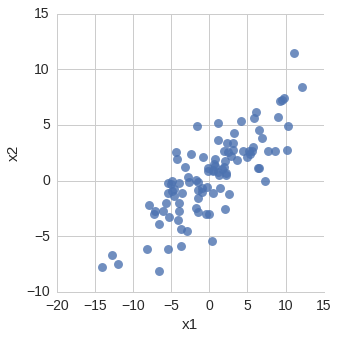

In [3]:
dataset = pd.read_csv('pca.csv',sep=',')
sns.lmplot(x="x1", y="x2", data=dataset, fit_reg=False, size=5, scatter_kws={"s": 80})
plt.show()

To apply PCA the data needs to be **centered** first. In this case it was centered already. PCA will search for the direction that preserves the most of the original variance. This is vector PC1 in the plot below.

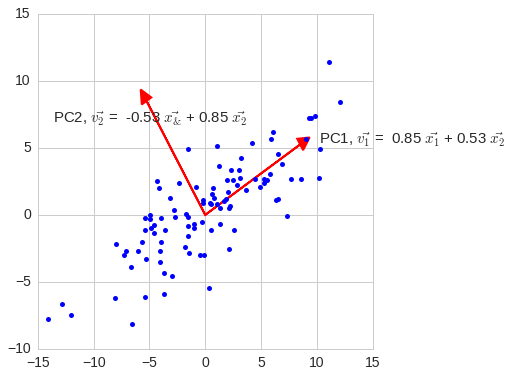

In [4]:
w,v=np.linalg.eig(np.cov(dataset.values.T)) #finds the eigenvalues and principle components (eigenvectors)

plt.figure(figsize=(6,6))
compomics_import.plot_eigenvectors(dataset,w,v)
plt.show()

The second principle component PC2 is orthogonal to PC1. These two new dimensions PC1 and PC2 now form a new space for the data points in which PC1 preserves (or explains) most of the variance in the data set. In general for a $n$-dimensional data set PCA will compute $n$ PCs such that PC1 explains most of the variance in the data set, PC2 explains most of the variance while being orthogonal to PC1, PC3 explains most of the variance while being orthogonal to PC1 and PC2, etc.

Each $i$-th PC has an **eigenvalue** $w_i$ that represents the variance (which was maximized) observed for the corresponding PC.

In [5]:
print "Eigenvalue for PC1 (w_0): %.2f" % (w[0])
print "Eigenvalue for PC2 (w_1): %.2f" % (w[1])

Eigenvalue for PC1 (w_0): 38.81
Eigenvalue for PC2 (w_1): 3.48


The amount of variance explained by each PC$i$ is given by

$$\frac{w_i}{\sum_j w_j},$$

where $j$ ranges over all PCs.

In [6]:
var_explained=100*w/sum(w)
print "Variance explained by PC1: %f" % var_explained[0]
print "Variance explained by PC2: %f" % var_explained[1]

Variance explained by PC1: 91.775895
Variance explained by PC2: 8.224105


The first principle component does indeed explain most variance in the original data set. The next step is to actually reduce the number of dimensions. If we would remove PC2 and project all data points to PC1 then we preserve 91.78% of the variance in the data set. If we remove PC1 and project all data points to PC2 we preserve only 8.22%. Clearly we want to project the original data set onto the top ranked PCs. For instance to visualize a $n$-dimensional data set we can project the data onto the first two or three PCs. 


Let's remove PC2 and project the data onto PC1. From the plot above we know that we can compute the data points for PC1 from the original features $x_1$ and $x_2$ as

$$\vec{v_1} =  0.85 \vec{x_1} + 0.53 \vec{x_2}.$$

We now replaced the features $x_1$ and $x_2$ by the feature $v_1$. This one dimensional data set can be plotted as a histogram:

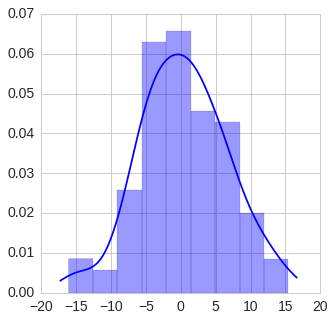

In [7]:
plt.figure(figsize=(5,5))
sns.distplot(v[0,0]*dataset['x1']+v[1,0]*dataset['x2'], color="b")
plt.show()

The variance of this distribution is thus 38.81. To show how PCA is applied using the PCA object in scikit-learn we first create an artificial data set with 100 samples in two classes. There are 100 features of which 10 are informative:

In [8]:
import sklearn.datasets as datasets

(dataset_big,targets) = datasets.make_classification(
n_samples=100,
n_features=100,
n_classes=2,
n_informative=10,
n_redundant=0,
n_repeated=0,
class_sep=2,
n_clusters_per_class=1,
random_state=2,
)

Now we apply PCA and keep only the two top principle components. The data set is projected (or transformed) onto these two new dimensions and plotted:

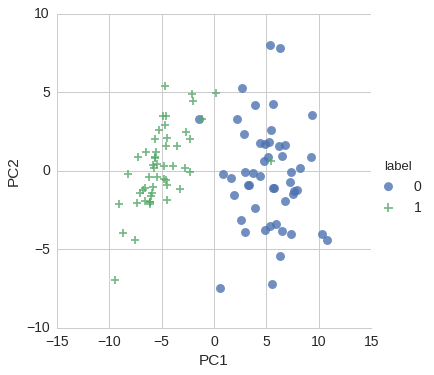

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
dataset_big_projected = pd.DataFrame(pca.fit(dataset_big).transform(dataset_big),columns=['PC1','PC2'])
dataset_big_projected['label'] = targets

sns.lmplot(x="PC1", y="PC2", data=dataset_big_projected, hue='label', markers=['o','+'],
           fit_reg=False, size=5.5, scatter_kws={"s": 80})
plt.show()

The plots reveals the two classes (remember these were not known to the PCA algorithm) and also reveals possible outliers in both classes. We can look at the explained variance for each PC:

In [10]:
print "Variance explained by PC1: %f" % pca.explained_variance_ratio_[0]
print "Variance explained by PC2: %f" % pca.explained_variance_ratio_[1]

Variance explained by PC1: 0.214116
Variance explained by PC2: 0.056570


We observe how PC1 and PC2 together only explain about 27% of the original variance while still providing useful structural information about the 100-dimensional data set.

MDS seeks a low-dimensional representation of the data in which the low-dimensional distances respect well the distances in the original high-dimensional space.

In general, it is a technique used for analyzing similarity or dissimilarity data. The algorithm starts from **distance matrix** rather then from a data set with feature vectors. This distance matrix contains the distances (dissimilarity) between the objects in a data set (e.g. interaction frequencies of molecules). So we don't necessarely have to represent the objects in the data set as feature vectors.

Let $\delta_{i,j}$ be the distance between object $i$ and object $j$ in the data set with $n$ objects. The distance matrix $\Delta$ can the be written as


\begin{pmatrix}
\delta_{1,1} & \delta_{1,2} & \cdots & \delta_{1,n} \\
\delta_{2,1} & \delta_{2,2} & \cdots & \delta_{2,n} \\
\vdots & \vdots & & \vdots \\
\delta_{n,1} & \delta_{n,2} & \cdots & \delta_{n,n}
\end{pmatrix}


The goal of MDS is, given $\Delta$, to find $n$ vectors $x_1,\ldots,x_n \in \mathbb{R}^N$ such that

$$\|x_i - x_j\| \approx \delta_{i,j}$$ 

for all 

$$i,j\in {1,\dots,n},$$

where $\|\cdot\|$ is a vector norm. In classical MDS, this norm is the Euclidean distance, but it may be any metric or arbitrary distance function.

Let's look at a typical example in which we don't want (or can't) represent the objects in the data set as feature vectors. Imagine we have collected car gps tracking data and used it to compute a distance matrix $\Delta$ in which the distance between two US cities is estimated by the average time a car required to travel between the cities. 

In this case we will be reading a distance matrix:

In [11]:
sim_matrix_cities = pd.read_csv('cities_us.csv',sep=' ')
sim_matrix_cities

,Atlanta,Chicago,Denver,Houston,LA,Miami,NYC,SF,Seattle,DC
0,0.000,0.587,1.212,0.701,1.936,0.604,0.748,2.139,2.182,0.543
1,0.587,0.000,0.920,0.940,1.745,1.188,0.713,1.858,1.737,0.597
2,1.212,0.920,0.000,0.879,0.831,1.726,1.631,0.949,1.021,1.494
3,0.701,0.940,0.879,0.000,1.374,0.968,1.420,1.645,1.891,1.225
4,1.936,1.745,0.831,1.374,0.000,2.339,2.451,0.347,0.959,2.500
5,0.604,1.188,1.726,0.968,2.339,0.000,1.092,2.594,2.734,0.923
6,0.748,0.713,1.631,1.420,2.451,1.092,0.000,2.571,2.408,0.205
7,2.139,1.858,0.949,1.645,0.347,2.594,2.571,0.000,0.678,2.442
8,2.182,1.737,1.021,1.891,0.959,2.734,2.408,0.678,0.000,2.329
9,0.543,0.597,1.494,1.225,2.500,0.923,0.205,2.442,2.329,0.000


MDS will plot these distances on a 2D map such that cities that require longer average driving times are positioned further away in the map. We should thus be able to reconstruct the US map:

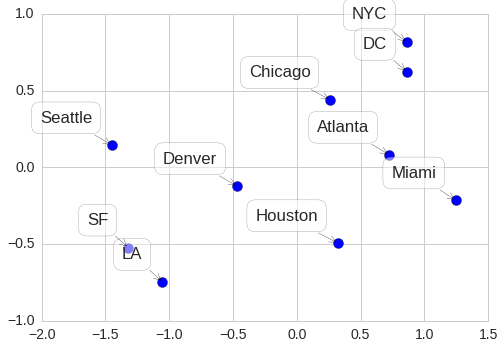

In [12]:
from sklearn import manifold

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=2,
                   dissimilarity="precomputed", n_jobs=1)
mds_coordinates = mds.fit(sim_matrix_cities).embedding_

compomics_import.plot_scatter_annotated(pd.DataFrame(mds_coordinates),sim_matrix_cities.columns.values)
plt.show()

We can see that the relative distances between the cities in the map are indeed correct. However, the map is rotated compared to the real map of the US. This is because the algorithm that computes the MDS coordinates starts with a random initialization of its model parameters, so every time you run MDS you well get a different rotation of the data. The MDS coordinates thus have no meaning other than representing distances between objects.

<strong>Exercises</strong>

- Load Breast Cancer Wisconsin data set and remove the label. Plot the first two principle components for the data sets. Plot the labels as the color of the data points.

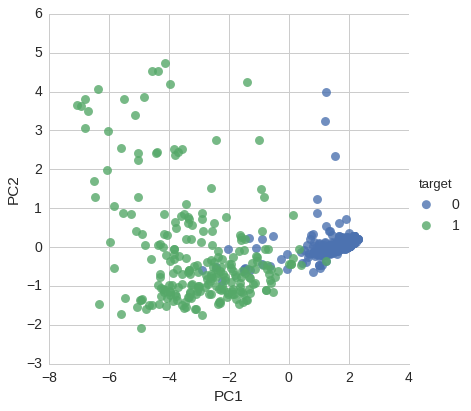

In [13]:
from sklearn.preprocessing import StandardScaler 

data_b = pd.read_csv("../breast-cancer-wisconsin.data")

ids = data_b.pop('id')
target = data_b.pop('Class')

cols = data_b.columns.values
scaler = StandardScaler()
scaler.fit(data_b)
data_b_norm = pd.DataFrame(scaler.transform(data_b),columns=cols)

pca = PCA(n_components=2)
data_b_projected = pd.DataFrame(pca.fit(data_b_norm).transform(data_b_norm),columns=['PC1','PC2'])
data_b_projected['target'] = target

sns.lmplot(x="PC1", y="PC2", data=data_b_projected,fit_reg=False, hue='target', size=6, scatter_kws={"s": 80})
plt.show()

- Let *KMeans* cluster the data set into 2 groups. Plot the data using the first two principle components (as in exercise 1) but this time use the cluster assignments to color the data points. 

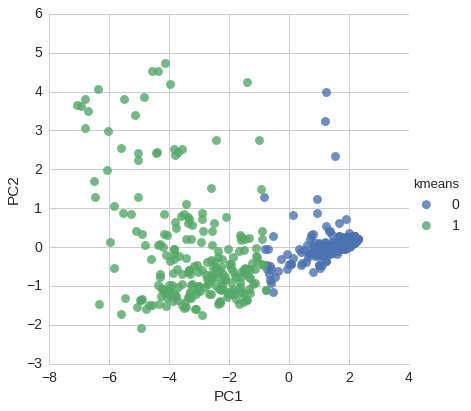

In [14]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2,max_iter=10)
km.fit(data_b_norm)

data_b_projected['kmeans'] = km.labels_

sns.lmplot(x="PC1", y="PC2", data=data_b_projected, hue="kmeans", fit_reg=False, size=6, scatter_kws={"s": 80})
plt.show()